# EuCNC 2021
This notebook contains the results derived to the scaling paper presented by 5Growth in EuCNC 2021:

## Environment - 80%/20% train/test

In [1]:
from TorinoEnvironment_eucnc import TorinoEnvironment

train_env, test_env = TorinoEnvironment(), TorinoEnvironment()
train_env.head(.8)
test_env.tail(.8)

55659
13915


In [2]:
train_env.monitorState('instant_work')

23.16

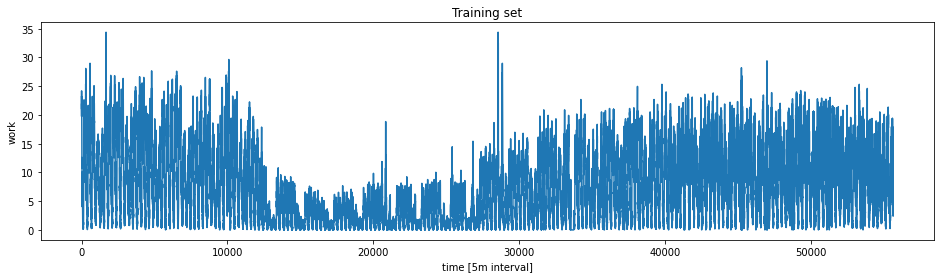

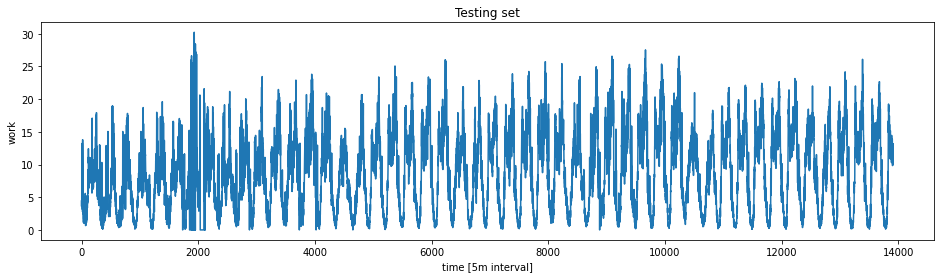

In [3]:
from matplotlib import pyplot as plt
train_env.plotWork()
plt.title('Training set');
test_env.plotWork()
plt.title('Testing set');

## PI

In [5]:
import numpy as np
import pandas as pd

def controllerPI(CPUload, alpha=2.0, beta=4.0, target=0.5):
    nrOfCPUs = len(CPUload)
    maxLoad = np.max(CPUload)
    difference = maxLoad - controllerPI.oldMaxLoad 
    controllerPI.oldMaxLoad = maxLoad
    delta = alpha*(maxLoad - target) + beta*difference 
    nrOfCPUs = int(nrOfCPUs + delta)
    return nrOfCPUs

In [7]:
%%time

test_env.resetState()

traceNrOfCPUs = np.zeros((test_env.duration,))
traceMaxCPUload = np.zeros((test_env.duration,))
traceSumBacklog = np.zeros((test_env.duration,))
traceReward = np.zeros((test_env.duration,))

nrOfCPUs = 21


x,y,z=[5.0, 5.0, 0.6] # best CONFIG TorinoScalingPI.ipynb

# Exec PI in the environment
time = 0
test_env.resetState()
controllerPI.oldMaxLoad = 0.0
while(not test_env.stop): 
    traceNrOfCPUs[time] = test_env.evolveState(nrOfCPUs)
    traceMaxCPUload[time] = np.max(test_env.monitorState('CPUload'))
    traceSumBacklog[time] = np.sum(test_env.monitorState('backlog'))
    traceReward[time] = test_env.getReward()
    nrOfCPUs = controllerPI(test_env.monitorState('CPUload'), alpha=x, beta=y, target=z)
    time += 1
    
# store the CSVs
pd.DataFrame({
    'nrOfCPUs': traceNrOfCPUs,
    'maxCPUload': traceMaxCPUload,
    'sumBacklog': traceSumBacklog,
    'reward': traceReward,
}).to_csv('eucnc2020-csvs/pi.csv')

CPU times: user 1.09 s, sys: 3.99 ms, total: 1.09 s
Wall time: 1.1 s


## Hysteresis

In [8]:
def controllerHysteresis(CPUload, minLoadThreshold=0.7, maxLoadThreshold=0.9):
    nrOfCPUs = len(CPUload)
    maxLoad = np.max(CPUload)
    if(maxLoad > maxLoadThreshold): nrOfCPUs += 1
    if(maxLoad < minLoadThreshold): nrOfCPUs -= 1
    return nrOfCPUs

In [10]:
%%time


traceNrOfCPUs = np.zeros((test_env.duration,))
traceMaxCPUload = np.zeros((test_env.duration,))
traceSumBacklog = np.zeros((test_env.duration,))
traceReward = np.zeros((test_env.duration,))

nrOfCPUs = 21


x, y = [0.5, 0.95] # best config according to TorinoScalingHysteresis.ipynb

time = 0
test_env.resetState()
while(not test_env.stop): 
    traceNrOfCPUs[time] = test_env.evolveState(nrOfCPUs)
    traceMaxCPUload[time] = np.max(test_env.monitorState('CPUload'))
    traceSumBacklog[time] = np.sum(test_env.monitorState('backlog'))
    traceReward[time] = test_env.getReward()
    nrOfCPUs = controllerHysteresis(test_env.monitorState('CPUload'), minLoadThreshold=x, maxLoadThreshold=y)
    time += 1
    
# store the CSVs
pd.DataFrame({
    'nrOfCPUs': traceNrOfCPUs,
    'maxCPUload': traceMaxCPUload,
    'sumBacklog': traceSumBacklog,
    'reward': traceReward,
}).to_csv('eucnc2020-csvs/hysteresis.csv')

CPU times: user 908 ms, sys: 1.9 ms, total: 910 ms
Wall time: 921 ms


## Constant number of CPUs

In [12]:
%%time

traceNrOfCPUs = np.zeros((test_env.duration,))
traceMaxCPUload = np.zeros((test_env.duration,))
traceSumBacklog = np.zeros((test_env.duration,))
traceReward = np.zeros((test_env.duration,))

nrOfCPUs = 21 # best setup according to TorinoScalingConstant.ipynb

time = 0
test_env.resetState()
while(not test_env.stop): 
    traceNrOfCPUs[time] = test_env.evolveState(nrOfCPUs)
    traceMaxCPUload[time] = np.max(test_env.monitorState('CPUload'))
    traceSumBacklog[time] = np.sum(test_env.monitorState('backlog'))
    traceReward[time] = test_env.getReward()
    time += 1

# store the CSVs
pd.DataFrame({
    'nrOfCPUs': traceNrOfCPUs,
    'maxCPUload': traceMaxCPUload,
    'sumBacklog': traceSumBacklog,
    'reward': traceReward,
}).to_csv('eucnc2020-csvs/constant.csv')

CPU times: user 830 ms, sys: 2 µs, total: 830 ms
Wall time: 832 ms


## Q-table
Initialize the Q-table.

In [4]:
from random import randint

# Q-table
ACTIONS = [1, 0, -1]
# ACTIONS = [2, 1, 0, -1, -2]
#ACTIONS = list(range(env.maximumNrOfCPUs+1))
Q = {
    ((W, N), a): 0 # reward
    for W in range(int(max(train_env.monitorState('work')))+1)
    for N in range(train_env.maximumNrOfCPUs+1)
    for a in ACTIONS
}

In [5]:
# Hyper-parameters
#alpha = 0.1
#gamma = 0.9
#EPISODES = 100


for ((W,N),a) in Q.keys():
    if W>N:
        Q[(W,N),-1] = 2*(N-W)
        Q[(W,N),0] = N-W
        Q[(W,N),1] = 1
    elif W==N:
        Q[(W,N),-1] = -1
        Q[(W,N),0] = 1
        Q[(W,N),1] = 0
    elif W<N:
        Q[(W,N),-1] = abs(N-W)
        Q[(W,N),0] = W-N
        Q[(W,N),1] = 2*(W-N)     

actions: [0, 1, -1, 1, 1, 0, 0, 0, 0, 1, -1, 0, -1, 1, -1, 1, 0, -1, 0]
EPISODE=99 -> achieved reward: -31067.867467207296


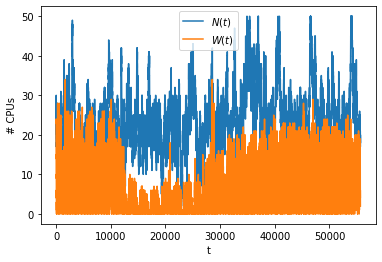

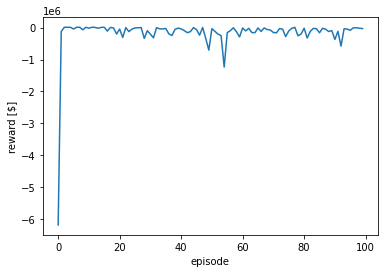

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import pandas as pd

# Hyper-parameters
alpha = 0.1
gamma = 0.9
EPISODES = 100
#epsilon = { # decreasing epsilon
#    ep: 1 - ep*0.9/len(train)
#    for ep in range(EPISODES)
#}
epsilon = { # epsilon-greedy approach
    ep: 0.1 # 1 - ep/EPISODES # --- varying
    for ep in range(EPISODES)
}



episode_rewards = []

for ep in range(EPISODES):
    
    #if ep > 0:
    #    break
    
    train_env.resetState()
    # SARSA variables
    # W[t], N[t]
    W = {0: int(train_env.monitorState('instant_work'))}
    N = {0: W[0]+1 }
    state  = {0: (W[0],N[0])}  # state[t]
    action = {}     # action[t]
    reward = {0: 0} # reward[t]
        
    
    for t in range(len(train_env.monitorState('work'))-1):
                   
        # Choose next action[t]
        action[t] = ACTIONS[np.argmax([Q[state[t], a] for a in ACTIONS])]\
                      if np.random.uniform() < epsilon[ep]\
                      else ACTIONS[randint(0, len(ACTIONS)-1)]
       
        #action[t]=0 # uncomenting this makes everything work
        # apparently everything breaks if you as more CPUs than
        #  the max
        
        # Take the action
        N[t+1] = N[t] + action[t]
        #N[t+1] = action[t]  # <--- if action = number of CPUs)
        #print(f'action[{t}]={action[t]} -- N[t+1]={N[t+1]}')
        train_env.evolveState(nrOfCPUs=N[t+1])
        #print(f'#backlog={len(env.monitorState("backlog"))} -- backlog={env.monitorState("backlog")}')
              
        # reward[t]
        reward[t] = train_env.getReward()
        
        # state[t+1]
        W[t+1] = int(train_env.monitorState('instant_work'))
        N[t+1] = len(train_env.monitorState('CPUload'))
        #W[t+1] = 0
        #N[t+1] = 0
        state[t+1] = (W[t+1], N[t+1])
                
        # Update Q-table
        Q[state[t], action[t]] = (1-alpha) * Q[state[t], action[t]] +\
                   alpha * (reward[t] + gamma*max([Q[state[t+1],a] for a in ACTIONS]))
    
    episode_rewards.append(sum(reward.values()))
    
    
    
    
    
    #########################
    # PLOT EPISODE PROGRESS #
    #########################
    # Print episode reward
    clear_output(wait=True)
    print(f'actions: {[action[t] for t in range(19)]}')
    #print(f'#CPUs: {N}')
    print(f'EPISODE={ep} -> achieved reward: {sum(reward.values())}')
    
    plt.plot(range(len(N.keys())), [N[t] for t in range(len(N.keys()))], label='$N(t)$')
    plt.plot(range(len(N.keys())), [W[t] for t in range(len(N.keys()))], label='$W(t)$')
    plt.xlabel('t'); plt.ylabel('# CPUs')
    plt.legend()
    plt.show()
    # Plot CDF progress
    #plt.ylim(bottom=-10, top=20000)
    plt.plot(range(ep+1), episode_rewards)
    plt.xlabel('episode'); plt.ylabel('reward [$]')
    plt.plot()
    plt.show()

Execute the trained network.

In [7]:
%%time

traceNrOfCPUs = np.zeros((test_env.duration,))
traceMaxCPUload = np.zeros((test_env.duration,))
traceSumBacklog = np.zeros((test_env.duration,))
traceReward = np.zeros((test_env.duration,))

nrOfCPUs = 21

time = 0
test_env.resetState()
while(not test_env.stop): 
    traceNrOfCPUs[time] = test_env.evolveState(nrOfCPUs)
    traceMaxCPUload[time] = np.max(test_env.monitorState('CPUload'))
    traceSumBacklog[time] = np.sum(test_env.monitorState('backlog'))
    traceReward[time] = test_env.getReward()
    
    W = int(test_env.monitorState('instant_work'))
    N = len(test_env.monitorState('CPUload'))
    state = (W, N)
    #print(state, [Q[state, a] for a in ACTIONS])
    action = ACTIONS[np.argmax([Q[state, a] for a in ACTIONS])]
    
    nrOfCPUs += action 
    time += 1

    
# store the CSVs
pd.DataFrame({
    'nrOfCPUs': traceNrOfCPUs,
    'maxCPUload': traceMaxCPUload,
    'sumBacklog': traceSumBacklog,
    'reward': traceReward,
}).to_csv('eucnc2020-csvs/qtable.csv')

CPU times: user 1.4 s, sys: 3.99 ms, total: 1.41 s
Wall time: 1.41 s
